# LangGraph `:)`

## First Things First

In [5]:
# !pip install --quiet -U langchain_openai langchain_core langchain_community tavily-python langgraph

In [33]:
import os
import random
from pprint import pprint
from google.colab import userdata
from IPython.display import display, Image
from typing import Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage, SystemMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

In [7]:
GIRU_OPENAI_API_KEY = userdata.get('GIRU_OPENAI_API_KEY')
GIRU_TAVILY_API_KEY = userdata.get('GIRU_TAVILY_API_KEY')
os.environ["OPENAI_API_KEY"] = GIRU_OPENAI_API_KEY
os.environ["TAVILY_API_KEY"] = GIRU_TAVILY_API_KEY

In [8]:
# checking openai llm
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
result = llm.invoke("Hi, are you deepseek?")

# printing results
print("==="*25)
print(f"RESPONSE\n{result.content}")
print("==="*25)
print("METADATA")
print(f"model: {result.response_metadata['model_name']}")
for k, v in result.response_metadata['token_usage'].items():
  print(f"{k}: {v}")

RESPONSE
No, I'm not DeepSeek. I'm an AI language model created by OpenAI. How can I assist you today?
METADATA
model: gpt-4o-mini-2024-07-18
completion_tokens: 25
prompt_tokens: 14
total_tokens: 39
completion_tokens_details: {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}
prompt_tokens_details: {'audio_tokens': 0, 'cached_tokens': 0}


In [9]:
# checking tavily tool
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("What is LangGraph?")
search_docs

# printing results
print("==="*25)
for doc in search_docs:
  for k, v in doc.items():
    print(f"{k}: {v}")
  print("==="*25)

title: Introduction to LangGraph: A Beginner's Guide - Medium
url: https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141
content: In this article, we’ll introduce LangGraph, walk you through its basic concepts, and share some insights and common points of confusion for beginners. While LangChain allows you to define chains of computation (Directed Acyclic Graphs or DAGs), LangGraph introduces the ability to add cycles, enabling more complex, agent-like behaviors where you can call an LLM in a loop, asking it what action to take next. Step 1: Define the Graph State First, we define the state structure for our graph. Step 4: Add Nodes to the Graph LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its power for their projects.
score: 0.8467682
title: LangGraph - LangChain
url: https://www.langchain.com/langgraph
content: Bu

## Session 1: Basics

 ### Simple Graph

In [10]:
# creating simple state
class State(TypedDict):
  graph_state: str

In [11]:
# functions are passed as nodes in graphs
# creating some functions/nodes

def node_a(state: State):
  print("---Node A---")
  return {"graph_state": state['graph_state'] + "Ball Thrown By A and "}

def node_b(state: State):
  print("---Node B---")
  return {"graph_state": state['graph_state'] + "Catched By B"}

def node_c(state: State):
  print("---Node C---")
  return {"graph_state": state['graph_state'] + "Catched By C"}

In [12]:
# creating simple edges kind of DAG
# creating function which will be working as a conditional edge

def decide_mood(state):
    user_input = state['graph_state']
    if random.random() < 0.5:
        return 0
    return 1

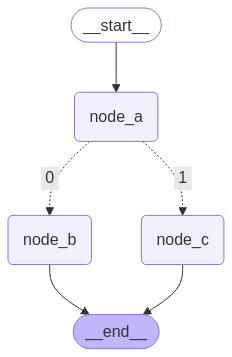

In [13]:
# first build skeleton of graph

# initialize the state
builder = StateGraph(State)

# add nodes and edges to graphs
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)

builder.add_edge(START, "node_a")

builder.add_conditional_edges(
    "node_a",
    decide_mood,
    {
        0: "node_b",
        1: "node_c"
    }
)

builder.add_edge("node_b", END)
builder.add_edge("node_c", END)

# compile the skeleton
graph = builder.compile()

# view the structure of graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
result = graph.invoke({"graph_state": "In the game of Catching Balls, "})

---Node A---
---Node C---


In [15]:
print(result['graph_state'])

In the game of Catching Balls, Ball Thrown By A and Catched By C


### Use of Messages & Tools

In [16]:
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Bhadwa"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Bhadwa"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Bhadwa

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Bhadwa

I want to learn about the best place to see Orcas in the US.


In [17]:
# we can convert functions into custom tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [18]:
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 times 3?")])
print(tool_call.tool_calls)

[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_7cm8Fy4j6326zigDLigAKN6O', 'type': 'tool_call'}]


### Tool Calling Assistant

In [19]:
# tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [20]:
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [23]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

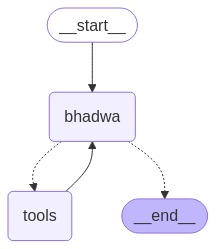

In [28]:
builder = StateGraph(MessagesState)
builder.add_node("bhadwa", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "bhadwa")

builder.add_conditional_edges(
    "bhadwa",
    tools_condition, # by default it checks whether any tool call made or not
)

builder.add_edge("tools", "bhadwa")
react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [29]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [30]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_4lDPEwTlVfDIhsx4bEC4exg4)
 Call ID: call_4lDPEwTlVfDIhsx4bEC4exg4
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_x8UBgIrotvmFj1lIp36qPgla)
 Call ID: call_x8UBgIrotvmFj1lIp36qPgla
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_134dF9a8DXYCQrYdRUMW7VRJ)
 Call ID: call_134dF9a8DXYCQrYdRUMW7VRJ
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

**Problem with simple Tool Calling Agent**  
It lacks memory, check below example -

In [32]:
messages = [HumanMessage(content="Add 3 and 4")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

messages = [HumanMessage(content="and multiply that by 4")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_3u23mVTlfJbAKfE7pN0fSbgb)
 Call ID: call_3u23mVTlfJbAKfE7pN0fSbgb
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

and multiply that by 4
================================== Ai Message ==================================

Please provide the number you would like to multiply by 4.


*It doesn't know what is that...*

### Tool Calling Agent with Memory

*We just simply have to add persistence via some kind of memory, below is example by using in-memory (default by langgraph)*

In [35]:
memory = MemorySaver()
react_graph_with_memory = builder.compile(checkpointer=memory)

First, we have to pass the memory into checkpointer while compiling graph.  
What it does?  
It creates a thread with some id and for that thread it stores or kind of checkpoints each node execution (not just last, instead all nodes) and hence, that thread kind of act as a memory for that session.

In [36]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_with_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_w5gUPRLnbBadCNJKwPWOWcYn)
 Call ID: call_w5gUPRLnbBadCNJKwPWOWcYn
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [37]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_with_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_w5gUPRLnbBadCNJKwPWOWcYn)
 Call ID: call_w5gUPRLnbBadCNJKwPWOWcYn
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QXDyp2DdlCXHkY0P2uEQj586)
 Call ID: call_QXDyp2DdlCXHkY0P2uEQj586
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

Multiplying 7 by 2 gi

## Session 2